In [12]:
import pandas as pd
import json
from numerapi import NumerAPI

In [13]:
napi = NumerAPI()

In [3]:
feature_metadata = json.load(open(f"../data/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

feature_sets 17
targets 37


In [4]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 705
all 2376


In [5]:
train = pd.read_parquet(
    f"../data/train.parquet"
)

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::4])]

<Axes: title={'center': 'Number of rows per era'}, xlabel='Era'>

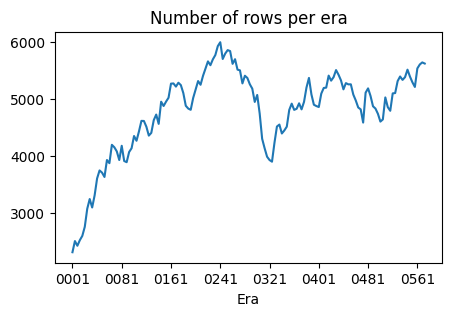

In [ ]:
# Plot the number of rows per era
train.groupby("era").size().plot(
    title="Number of rows per era",
    figsize=(5, 3),
    xlabel="Era"
)

<Axes: title={'center': 'Target'}, xlabel='Value', ylabel='Frequency'>

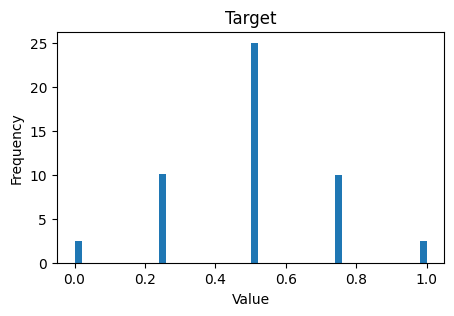

In [ ]:
# Plot density histogram of the target
train["target"].plot(
  kind="hist",
  title="Target",
  figsize=(5, 3),
  xlabel="Value",
  density=True,
  bins=50
)

KeyError: 'l'

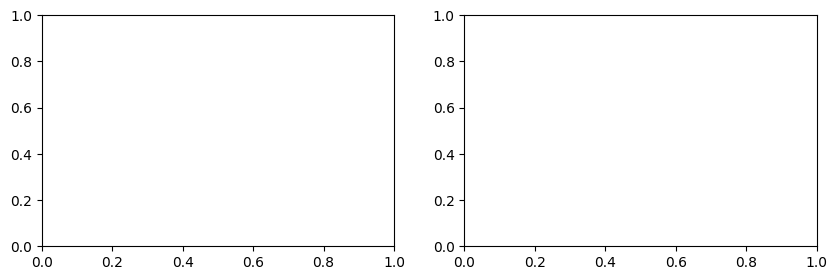

In [11]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era = train[train["era"] == train["era"].unique()[-1]]
last_era[feature_set[-1]].plot(
   title="5 equal bins",
   kind="hist",
   density=True,
   bins=50,
   ax=ax1
)
first_era[feature_set[-1]].plot(
   title="missing data",
   kind="hist",
   density=True,
   bins=50,
   ax=ax2
)

In [8]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
import lightgbm as lgb

# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)
# We've found the following "deep" parameters perform much better, but they require much more CPU and RAM
# model = lgb.LGBMRegressor(
#     n_estimators=30_000,
#     learning_rate=0.001,
#     max_depth=10,
#     num_leaves=2**10,
#     colsample_bytree=0.1
#     min_data_in_leaf=10000,
# )
feature_set = [col for col in train.columns if col != 'target' and col != 'era' and col != 'data_type']
# This will take a few minutes 🍵
model.fit(
  train[feature_set],
  train["target"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12062
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 2412
[LightGBM] [Info] Start training from score 0.500008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000)

In [9]:
validation = pd.read_parquet(
    f"../data/validation.parquet",
    columns=["era", "data_type", "target"] + feature_set
)
validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]

# Downsample to every 4th era to reduce memory usage and speedup evaluation (suggested for Colab free tier)
# Comment out the line below to use all the data (slower and higher memory usage, but more accurate evaluation)
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# Generate predictions against the out-of-sample validation features
# This will take a few minutes 🍵
validation["prediction"] = model.predict(validation[feature_set])
validation[["era", "prediction", "target"]]

,era,prediction,target
id,,,
n000c290e4364875,0579,0.501277,0.50
n002a15bc5575bbb,0579,0.248155,0.25
n00309caaa0f955e,0579,0.735588,0.75
n0039cbdcf835708,0579,0.505638,0.50
n004143458984f89,0579,0.498488,0.50
...,...,...,...
nfff25c0fac1ffd6,1151,0.498233,0.50
nfff53f275fc23e2,1151,0.744912,0.75
nfff68da2902848d,1151,0.524238,0.50


In [15]:
# install Numerai's open-source scoring tools
#!pip install -q --no-deps numerai-tools

# import the 2 scoring functions
from numerai_tools.scoring import numerai_corr, correlation_contribution

# Download and join in the meta_model for the validation eras
napi.download_dataset(f"v4.3/meta_model.parquet", round_num=842)
validation["meta_model"] = pd.read_parquet(
    f"v4.3/meta_model.parquet"
)["numerai_meta_model"]

2025-03-07 12:02:32,522 INFO numerapi.utils: resuming download
/Users/marcofurrer/Documents/github/dspro2/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'numerai-datasets-us-west-2.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
v4.3/meta_model.parquet: 29.0MB [00:27, 1.06MB/s]                            


/var/folders/9c/04w_v9pn62q4ccpxc0bq3lbh0000gn/T/ipykernel_7895/295801370.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_corr = validation.groupby("era").apply(
/var/folders/9c/04w_v9pn62q4ccpxc0bq3lbh0000gn/T/ipykernel_7895/295801370.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_era_mmc = validation.dropna().groupby("era").apply(


<Axes: title={'center': 'Validation MMC'}, xlabel='era'>

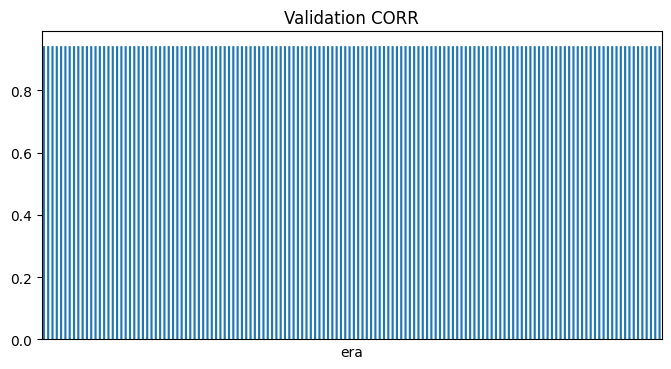

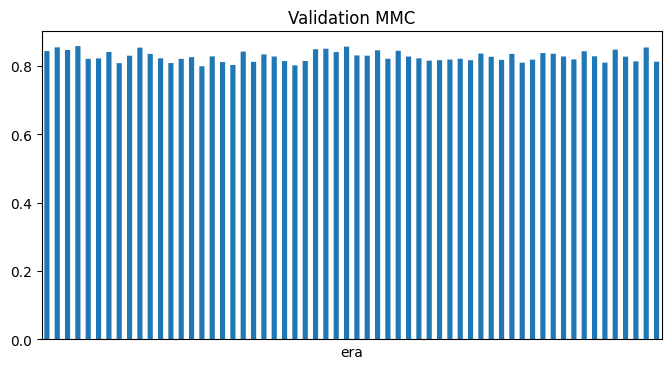

In [16]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

<Axes: title={'center': 'Cumulative Validation MMC'}, xlabel='era'>

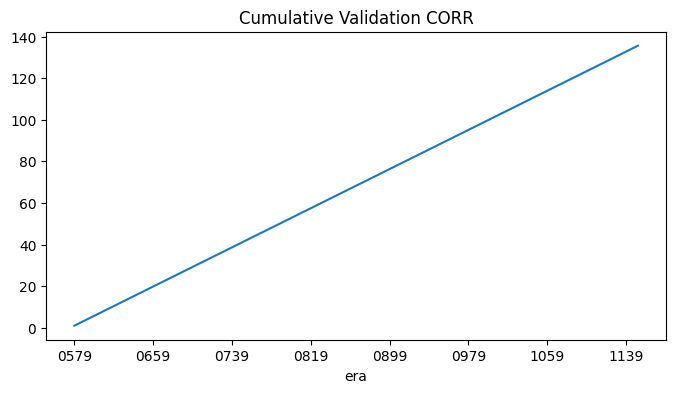

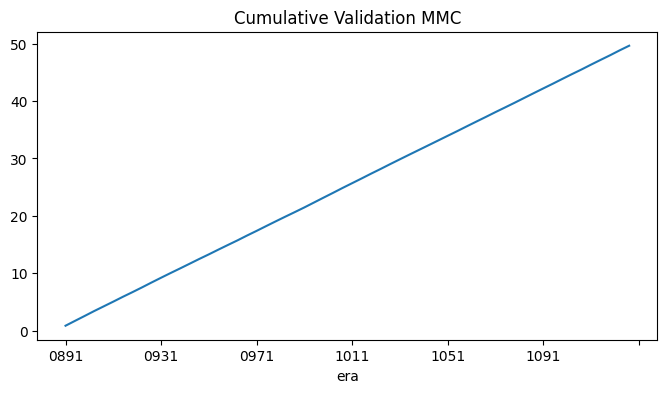

In [17]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

In [18]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

,CORR,MMC
mean,prediction 0.941594 dtype: float64,prediction 0.827531 dtype: float64
std,prediction 0.000048 dtype: float64,prediction 0.014937 dtype: float64
sharpe,prediction 19489.559074 dtype: float64,prediction 55.400777 dtype: float64
max_drawdown,prediction 0.0 dtype: float64,prediction 0.0 dtype: float64


In [19]:


# Load live features
live_features = pd.read_parquet(f"../data/live.parquet", columns=feature_set)

# Generate live predictions
live_predictions = model.predict(live_features[feature_set])

# Format submission
pd.Series(live_predictions, index=live_features.index).to_frame("prediction")

,prediction
id,
n001775ef80c9a46,-0.006249
n002e8a888b4ae0c,-0.006062
n002f664bbff3730,-0.011117
n0040131291ab478,-0.004293
n00515c75fbeae40,-0.002761
...,...
nffc733dd53e0053,-0.008694
nffcbe06fa6519eb,-0.011654
nffd52b67266fd79,-0.007643


In [20]:
# Define your prediction pipeline as a function
def predict(live_features: pd.DataFrame) -> pd.DataFrame:
    live_predictions = model.predict(live_features[feature_set])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

In [22]:
# Use the cloudpickle library to serialize your function
import cloudpickle
p = cloudpickle.dumps(predict)
with open("hello_numerai.pkl", "wb") as f:
    f.write(p)